Testing precip filter on month of CPM data //
Jan 2005 //
Threhsold = [240, 200] //
n_min_threshold = [1975, 10]

In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from six.moves import urllib
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import functions
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [7]:
# Import datasets
mask = xr.open_dataset('Save/Mask_Segmentation_tb_precip_test.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

#mask_2 = iris.load_cube('Save/Mask_Segmentation_tb_precip_test.nc')

precip = xr.open_dataset('/data/users/hgilmour/total_precip/precip_instant/precip_jan_2005.nc')
precip = precip.stratiform_rainfall_flux #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('Save/Track_precip_test.h5', 'table')

In [8]:
print(mask[274,:,:])

<xarray.DataArray 'segmentation_mask' (latitude: 1360, longitude: 1360)>
[1849600 values with dtype=int32]
Coordinates:
    time                     datetime64[ns] 2005-01-12T10:30:00
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    long_name:  segmentation_mask
    units:      1


In [132]:
mask.shape == precip.shape # checking whether the mask and precip files have the same shape
# next steps won't work if not

True

In [133]:
# Copy tracks dataset into new tracks_precip dataset to append precip data to
tracks = tracks.copy()

In [134]:
# Add columns to the tracks_precip dataframe ready to append data to later
tracks['total_precip'] = 0
tracks['rain_flag'] = 0
tracks['convective_precip'] = 0

In [135]:
# remove cell values with -1 from tracks dataset
tracks = tracks[tracks.cell >= 0]
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,convective_precip
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00,0,0,0
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00,0,0,0
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,0,0,0
11,0,326,1136.057059,1330.881404,3448,240,12,2005-01-01 00:30:00,2005-01-01 00:30:00,5.970260,-31.139263,328.860737,328.860737,12,0 days 00:00:00,0,0,0
12,1,7,179.948634,523.925062,4138,240,13,2005-01-01 01:30:00,2005-01-01 01:30:00,-32.752130,-63.820969,296.179031,296.179031,1,0 days 01:00:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,742,351,1126.995562,1076.654673,15042,240,9063,2005-01-31 22:30:00,2005-01-31 22:30:00,5.603271,-41.435432,318.564568,318.564568,2222,0 days 08:00:00,0,0,0
9064,743,28,506.670650,519.857317,40563,240,9065,2005-01-31 23:30:00,2005-01-31 23:30:00,-19.519889,-63.985728,296.014272,296.014272,2193,0 days 15:00:00,0,0,0
9070,743,97,627.143818,585.244022,13066,240,9071,2005-01-31 23:30:00,2005-01-31 23:30:00,-14.640726,-61.337561,298.662439,298.662439,2218,0 days 10:00:00,0,0,0
9074,743,208,801.606743,355.515817,3839,240,9075,2005-01-31 23:30:00,2005-01-31 23:30:00,-7.574979,-70.641556,289.358444,289.358444,2233,0 days 06:00:00,0,0,0


In [91]:
# # make array of cell numbers:

# s = generate_binary_structure(2,2) # need this in loop later on
# removed = 0 # need this for loop later on
# precip_area = 2

# for cell in np.unique(tracks.cell.values): #looping through each unique MCS cell
#     subset = tracks[tracks.cell == cell] # creating a subset of unique tracks
#     precipitation_flag = 0 # creating this for later

#     for idx in subset.idx.values:
#         print(idx)
#         if mask.shape == precip.shape:
#             seg = mask[idx,:,:]
#             prec = precip[idx,:,:]

#             featureid = subset.feature[subset.idx == idx].values[0]
            
            
#             labels, nr = ndimage.label(seg, structure = s)

#             if featureid not in seg:
#                 continue
#             else:

#                 label = np.unique(labels[seg == featureid])[0]
#                 seg_mask = seg.where(labels == label)

#                 #create coordinates from mask
#                 seg_mask.coords['mask'] = (('lon', 'lat'), seg_mask)
#                 #apply mask to precip dataset
#                 precip_values = prec.T.where(seg_mask.coords['mask'].values > 0)
#                 array = precip_values.values.flatten()
#                 values = array[~np.isnan(array)] #amount of grid cells with precip
#                 print(values)
#                 total_precip = np.nansum(values[values > 0]) * 3600
#                 tracks['total_precip'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = total_precip
#                 rain_features = values[values >= 1].shape[0] #1 is the precip threshold (1mm/hr)
#                 tracks['convective_precip'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = np.nansum(values[values >= 1]) * 3600
#                 tracks['rain_flag'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = rain_features

#                 if rain_features >= precip_area:
#                     precipitation_flag += rain_features

#     if precipitation_flag == 0:
#         #remove corresponding cell from the tracks dataframe
#         tracks = tracks.drop(tracks[tracks.cell == cell].index)
#         removed += 1

# # save precip track files
# tracks.to_hdf('Save/Tracks_precip_Jan_2005_test.h5', 'table')





        


328
289
243
195
193
189
205
190
174
194
186
225
245
260
257
292
429
506
532
503
488
444
369
345
278
275
270
261
227
229
208
193
170
170
157
168
176
195
211
217
347
389
423
428
389
392
342
286
216
207
186
193
208
172
153
208
197
202
263
244
206
256
301
352
415
477
478
456
422
401
282
273
261
234
227
226
216
204
221
235
238
240
299
292
262
302
349
324
446
533
488
442
376
322
300
256
225
202
225
220
245
231
240
206
228
213
227
205
191
161
212
210
278
330
398
419
380
337
294
279
264
276
231
246
220
243
202
204
176
163
153
130
159
159
172
195
269
372
398
366
341
294
257
203
228
206
203
171
167
166
194
197
199
198
183
165
159
166
155
183
242
313
344
378
362
326
315
305
269
220
214
213
205
195
178
181
184
174
170
162
154
163
185
221
261
375
401
419
381
408
349
316
270
268
241
259
243
229
226
215
220
219
211
197
167
189
223
224
318
343
353
373
398
364
354
332
275
283
251
257
262
242
217
258
253
221
210
226
221
229
233
269
345
417
453
430
378
340
316
295
290
268
220
263
224
224
189
192
233
214


In [136]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,convective_precip
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00,0,0,0
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00,0,0,0
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,0,0,0
11,0,326,1136.057059,1330.881404,3448,240,12,2005-01-01 00:30:00,2005-01-01 00:30:00,5.970260,-31.139263,328.860737,328.860737,12,0 days 00:00:00,0,0,0
12,1,7,179.948634,523.925062,4138,240,13,2005-01-01 01:30:00,2005-01-01 01:30:00,-32.752130,-63.820969,296.179031,296.179031,1,0 days 01:00:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,742,351,1126.995562,1076.654673,15042,240,9063,2005-01-31 22:30:00,2005-01-31 22:30:00,5.603271,-41.435432,318.564568,318.564568,2222,0 days 08:00:00,0,0,0
9064,743,28,506.670650,519.857317,40563,240,9065,2005-01-31 23:30:00,2005-01-31 23:30:00,-19.519889,-63.985728,296.014272,296.014272,2193,0 days 15:00:00,0,0,0
9070,743,97,627.143818,585.244022,13066,240,9071,2005-01-31 23:30:00,2005-01-31 23:30:00,-14.640726,-61.337561,298.662439,298.662439,2218,0 days 10:00:00,0,0,0
9074,743,208,801.606743,355.515817,3839,240,9075,2005-01-31 23:30:00,2005-01-31 23:30:00,-7.574979,-70.641556,289.358444,289.358444,2233,0 days 06:00:00,0,0,0


In [118]:
# make array of cell numbers:

s = generate_binary_structure(2,2) # need this in loop later on
removed = 0 # need this for loop later on
precip_area = 2
precipitation_flag = 0 # creating this for later


tracks=tracks[tracks.cell >= 0]
#print(tracks.cell.unique) #looping through each unique MCS cell

#choosing cell 8 as the example cell:

subset = tracks[tracks.cell == 8] # creating a subset of a unique track
#print(subset)

for idx in subset.idx.values: #find all the idx values for that unique cell / track (an idx is a unique value for each feature in a frame /timestep)
    print(idx)
    if mask.shape == precip.shape:
        seg = mask[idx,:,:] #printing the segmentation mask which occurs in the same frame as the cell idx value
        #print(seg)
        prec = precip[idx,:,:] #printing the precip timestep which occurs in the same frame as the cell idx value
        #print(prec)

        featureid = subset.feature[subset.idx == idx].values[0] #find the feature number at each timestep / frame of the cells lifetime (it changes over time and doesn't stay constant)
        print(featureid) #we now know all the feature numbers that belong to a single cell over its lifetime
            
            
        labels, nr = ndimage.label(seg, structure = s) #this line uses ndimage package for image processing. It generates arrays of numbers and decides what are joined together and what aren't.
        # In other words, it does image segmentation tasks, such as finding connected components and labeling objects in an image.
        # (i.e. it generates the locations of all contiguous fields of the segmentation mask that belong to a specific cell at a specific timestep and gives it a label. The number of labels is also recorded (the number of segmented areas in the timestep))

        if featureid not in seg: #check that the feature id number at each timestep is within the segmentation mask, if not, it is ignored and we continue
            continue
        else:

            label = np.unique(labels[seg == featureid])[0]
            seg_mask = seg.where(labels == label)
            #print(seg_mask)

#                 #create coordinates from mask
#                 seg_mask.coords['mask'] = (('lon', 'lat'), seg_mask)
#                 #apply mask to precip dataset
#                 precip_values = prec.T.where(seg_mask.coords['mask'].values > 0)
#                 array = precip_values.values.flatten()
#                 values = array[~np.isnan(array)] #amount of grid cells with precip
#                 print(values)
#                 total_precip = np.nansum(values[values > 0]) * 3600
#                 tracks['total_precip'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = total_precip
#                 rain_features = values[values >= 1].shape[0] #1 is the precip threshold (1mm/hr)
#                 tracks['convective_precip'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = np.nansum(values[values >= 1]) * 3600
#                 tracks['rain_flag'][(tracks.feature == featureid) & (tracks.idx == idx) & (tracks.cell == cell)] = rain_features

#                 if rain_features >= precip_area:
#                     precipitation_flag += rain_features

#     if precipitation_flag == 0:
#         #remove corresponding cell from the tracks dataframe
#         tracks = tracks.drop(tracks[tracks.cell == cell].index)
#         removed += 1

# # save precip track files
# tracks.to_hdf('Save/Tracks_precip_Jan_2005_test.h5', 'table')





        


274
8
246
24
207
41
151
54
153
69
161
83
178
98
166
111


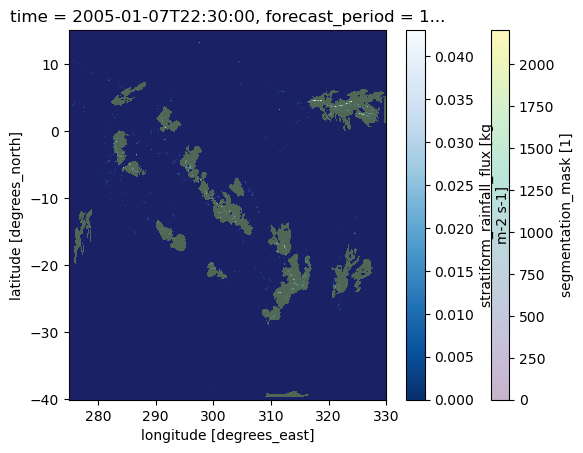

In [84]:
mask[166,:,:].plot(alpha=0.3,zorder=5)
precip[166,:,:].plot(cmap='Blues_r')

In [83]:
print(subset.feature[subset.idx == 166].values[0])
print(subset)

111
     frame  idx       hdim_1      hdim_2   num  threshold_value  feature  \
7        0  274   994.600931  652.721131  3251              240        8   
23       1  246   997.302790  649.673525  3985              240       24   
40       2  207  1000.085394  647.171876  4462              240       41   
53       3  151  1003.611792  643.427105  4439              240       54   
68       4  153  1001.760375  637.916268  3516              240       69   
82       5  161  1002.426140  633.101328  1978              240       83   
97       6  178   999.329845  589.566796  2196              240       98   
110      7  166  1005.332832  573.307600  2083              240      111   

                    time              timestr  latitude  longitude  \
7    2005-01-01 00:30:00  2005-01-01 00:30:00  0.241288 -58.604738   
23   2005-01-01 01:30:00  2005-01-01 01:30:00  0.350713 -58.728157   
40   2005-01-01 02:30:00  2005-01-01 02:30:00  0.463408 -58.829496   
53   2005-01-01 03:30:00  2005-

In [88]:
nr

16

In [134]:
labels >=1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])